In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import imageio
import moviepy
import random
import time
from itertools import permutations
from collections import defaultdict
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [2]:
def sig_func(x,y):
    return(1/(1+np.exp(-(np.dot(x,y)))))

In [3]:
def mutate(x,rate):
    chosen = np.random.choice(range(0,len(x)),rate,replace=False)
    for i in range(0,len(x)):
        if i in chosen:
            x[i] = float(2*np.random.random(1)-1)
    return(x)

In [4]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [5]:
def extract_tribe(cells, cell_weights, labels, node_n = 225):
    db = DBSCAN().fit(cell_weights)
    flags = []
    for k in labels:
        flags = [flags, [j for j, x in enumerate(db.labels_ == k) if x]]
    next_cells = cells[flags,:]  
    next_weights = cell_weights[flags,:]
    return(next_cells, next_weights, db)

In [6]:
def slime(x = None,
          y = None,
          start_pop = 25,
          max_age = 100,
          fig_size = [5,5],
          board_size = 100,
          max_hp = 6,
          baby_hp = 3,
          log = False,
          frames=500,
          interval=50,
          mutation_rate = 20,
          willing_wait = 10,
          mode='once'):
    
    global sight
    global time_tick
    global grow_count
    global birth_count
    global bump_count
    global trends
    global cells
    global cell_weights
    global cell_name
    global killed
    global border
    global last_time
    global new_coord
    global G
    global for_gif
    
    sight = 9
    G = nx.Graph()
    time_tick = 0
    trends = np.array([0,0,0,0,0,0])
    border = round(board_size/3)
    last_time = 0
    cell_name = 1
    new_coord = [[-1,1],
                 [0,1],
                 [1,1],
                 [-1,0],
                 [0,0],
                 [1,0],
                 [-1,-1],
                 [0,-1],
                 [1,-1]]
    
    # Build the initial cell list.  NN is built around sight/input of 5, movement/output of 3.
    if(x == None):
        cells = np.zeros((start_pop,5))
        cell_weights = np.zeros((start_pop,(sight*sight*3*3)))
        
        for cell in range(0,start_pop):
            cells[cell,:] = [cell_name,
                          np.random.choice(range(border, board_size-border)),
                          np.random.choice(range(border, board_size-border)),
                          baby_hp,
                          1]
            cell_weights[cell,:] = 2*np.random.random((sight*sight*3*3))-1
            G.add_node(cell)
            cell_name += 1
            
    else:
        cells = x
        cell_weights = y

    # Create the board.
    X = np.zeros(shape=(board_size,board_size))
    for_gif = X
    
    # initialization function: plot the background of each frame
    def init():
        im.set_data(X)
        return (im,)
    
    # Get the coodinates for the input.
    L = [0, 0, 1, 1, -1, -1, 2, 2, -2, -2, 3, 3, -3, -3, 4, 4, -4, -4]
    keep = [0,0]
    
    for comb in permutations(L, r=2):
        keep = np.vstack((keep, comb))
    
    # Setup plotting.
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='hot', interpolation='nearest')
    im.set_clim(0, 8)
        
    def animate(i):
        global sight
        global time_tick
        global grow_count
        global birth_count
        global bump_count
        global trends
        global cells
        global cell_weights
        global cell_name
        global total_pop
        global killed
        global border
        global last_time
        global new_coord
        global G
        global for_gif
        
        grow_count = 0
        birth_count = 0
        bump_count = 0
        
        # Saftey net for long runs.
        if(last_time > willing_wait):
            print("Taking too long...")
            return()
        
        start_time = time.time()
        
        killed_this_round = np.array([], dtype = int)
                
        # Take turns through the cell list.
        time_tick += 1
        im.set_data(animate.X)
        
        for cell in range(0, len(cells)):
            # Input.
            test_in = []
            for perm in np.mod(cells[cell,1:3] + np.unique(keep,axis=0), board_size):
                test_in = np.append(test_in, X[int(perm[0]), int(perm[1])])

            # Output.
            test_out = sig_func(test_in,cell_weights[cell,:].reshape((sight*sight, 3*3)))
            d = test_out.argmin()

            # Stay and Grow.
            if(d==4):

                if(cells[cell,3] < 5):
                    cells[cell,3] += 1
                    grow_count += 1

                    if(log == True):
                        print("{0} grew to size {1}.".format(cells[cell,0], cells[cell,3]))

                # Handle birth/splitting, don't clear.
                if(cells[cell,3] >= max_hp):
                    # Half its size.
                    cells[cell,3] = baby_hp

                    # Give the baby attributes and mutate the NN.
                    baby_name = cell_name
                    G.add_node(baby_name)
                    G.add_edge(cell_name, baby_name)
                    cell_name += 1

                    a = [baby_name,
                         np.random.choice(range(board_size)),
                         np.random.choice(range(board_size)),
                         baby_hp,
                         1]
                    b = mutate(cell_weights[cell,:], mutation_rate)
                    cells = np.vstack((cells, a)) 
                    cell_weights = np.vstack((cell_weights, b))
                    X[int(cells[cell,1]), int(cells[cell,2])] = abs(sum(b))

                    # Get the coodinates for possible baby locations.
                    L = [0, 0, 1, 1, -1, -1]
                    keep2 = [0,0]

                    for comb in permutations(L, r=2):
                        keep2 = np.vstack((keep2, comb))

                    potential = []
                    for perm in np.mod(cells[cell,1:3] + np.unique(keep2,axis=0), board_size):
                        potential = np.append(potential, X[int(perm[0]), int(perm[1])])

                    clear = []
                    for i in potential:

                        if(i == 0):
                            clear = np.append(clear,i)

                    if(len(clear) > 0):
                        d = np.random.choice(range(0,len(clear)))

                        # Give new coordinate and fill it in.
                        destination = np.mod(np.add(cells[int(cell),1:3], new_coord[d]), board_size)
                        cells[-1,1:3] = destination
                        X[int(destination[0]), int(destination[1])] = abs(sum(cell_weights[cell,:]))

                        birth_count += 1

                        if(log == True):
                            print("{0} underwent mitosis.  Gave birth to {1}.".format(cells[cell,0], baby_name))

            # Move.
            else:
                # If it is clear to move.
                destination = np.mod(np.add(cells[cell,1:3].astype(float), new_coord[d]), board_size)

                if(X[int(destination[0]), int(destination[1])] == 0):
                    # Clear where it was if not splitting.
                    last_spot = cells[cell,1:3]
                    X[int(last_spot[0]),int(last_spot[1])] = 0         

                    # Give new coordinate and fill it in.
                    cells[cell,1:3] = destination
                    X[int(destination[0]), int(destination[1])] = abs(sum(cell_weights[cell,:]))

                else:
                    # It gets bumped.    
                    x = [i for i, j in enumerate(cells[:,1]) if j == destination[0]]
                    y = [i for i, j in enumerate(cells[:,2]) if j == destination[1]]
                    z = intersection(x,y)

                    if(len(z) == 1):

                        eff = 0.9
                        rat = np.log(cells[z,4]/cells[cell,4])/10

                        if(cells[cell,3] > cells[z,3]):
                            cells[cell,3] += np.round(3*eff+rat)
                            cells[z,3] -= np.round(3+rat)

                        if(cells[cell,3] == cells[z,3]):
                            cells[cell,3] += np.round(1*eff+rat)
                            cells[z,3] -= np.round(1+rat)

                        if(cells[cell,3] < cells[z,3]):
                            cells[cell,3] -= np.round(2*eff-rat)
                            cells[z,3] += np.round(2-rat)  

                        bump_count += 1

                        if(log == True):
                            print("{0} was injured to size {1}!".format(cells[cell,0], cells[cell,3]))

                        # Handle death.
                        if(cells[cell,3] < 1):
                            # Clear where it was and delete from list.
                            last_spot = cells[cell,1:3]
                            X[int(last_spot[0]),int(last_spot[1])] = 0
                            killed_this_round = np.append(killed_this_round,int(cells[cell,0]))

                            if(log == True):
                                print("{0} died!.".format(cells[cell,0]))

                        try:
                            if(cells[z,3] < 1):

                                # Clear where it was and delete from list.
                                last_spot = cells[z,1:3]
                                X[int(last_spot[0]),int(last_spot[1])] = 0
                                killed_this_round = np.append(killed_this_round,int(cells[z,0]))

                                if(log == True):
                                    print("{0} died!.".format(cells[z,0]))

                        except:
                            pass             
        
        # Kill the elderly
        cells[:,4] = np.add(cells[:,4],1)
        
        for i in range(0,len(cells)):
            if(cells[int(i),4] > max_age):
                # Blur max age a bit
                if(np.random.random() < (cells[int(i),4]-max_age)/max_age):      
                    # Clear where it was and delete from list.
                    last_spot = cells[cell,1:3]
                    X[int(last_spot[0]),int(last_spot[1])] = 0
                    killed_this_round = np.append(killed_this_round,int(cells[cell,0]))

                    if(log == True):
                        print("{0} died of old age!.".format(cells[cell,0]))
                    
        for i in np.unique(killed_this_round):
            j = list(cells[:,0]).index((i))
            cells = np.delete(cells, (j), axis=0)
            cell_weights = np.delete(cell_weights, (j), axis=0)
        
        run_pop = len(cells)
        death_count = len(np.unique(killed_this_round))
            
        current = np.array([time_tick, grow_count, birth_count, bump_count, death_count, run_pop])                
        trends = np.vstack((trends, current))
        
        
        for_gif = np.concatenate((for_gif, X))
        last_time = time.time() - start_time
    
        return (im,)
        
    animate.X = X
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=interval, blit=True)
    html_result = display_animation(anim, default_mode=mode)
    
    # Make a little gif
    images = []
    for i in range(0,(frames+1)):
        imageio.imwrite('slime.gif', np.reshape(for_gif,((frames+1),board_size,board_size))[int(i),:,:])
        images.append(imageio.imread('slime.gif'))
    imageio.mimsave('slime.gif', images)
    
    return (html_result, cells, cell_weights, G, trends[1:,:], for_gif)


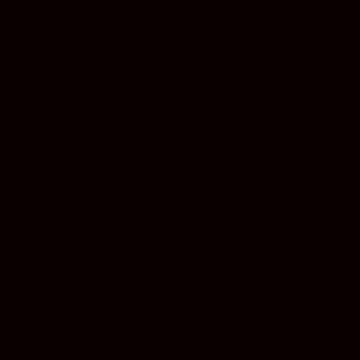
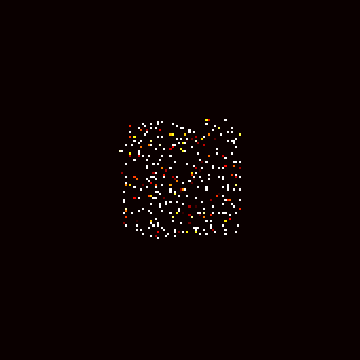
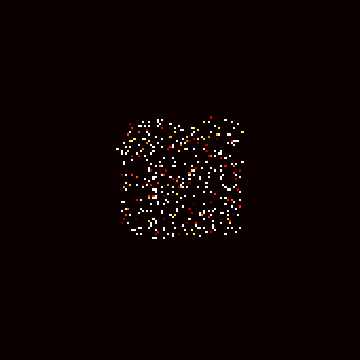
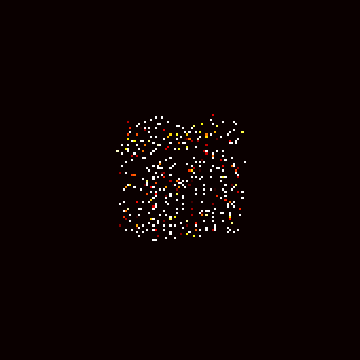
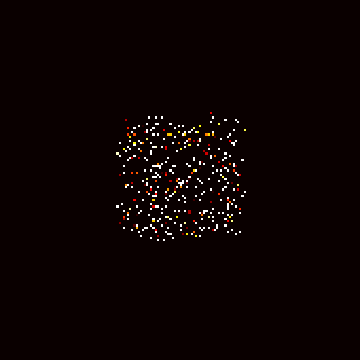
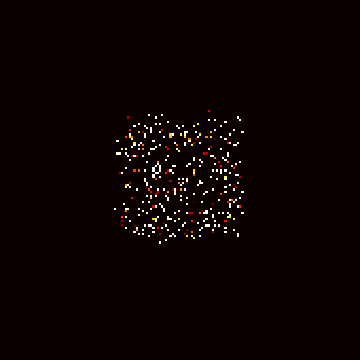
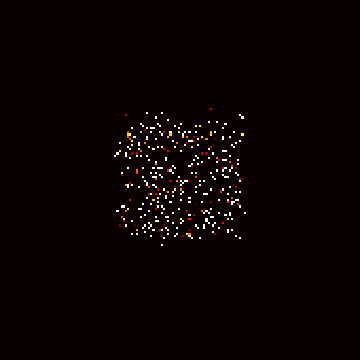
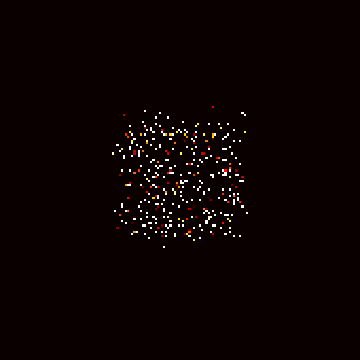
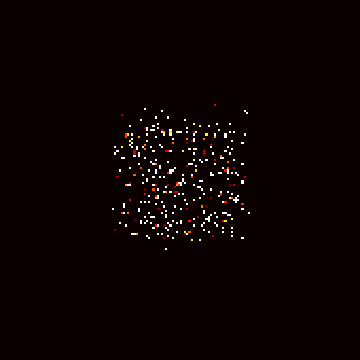
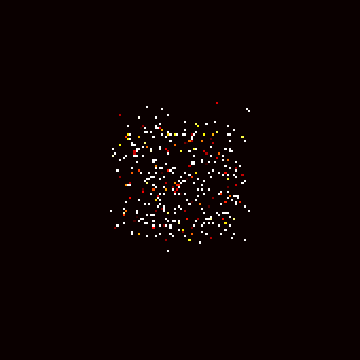
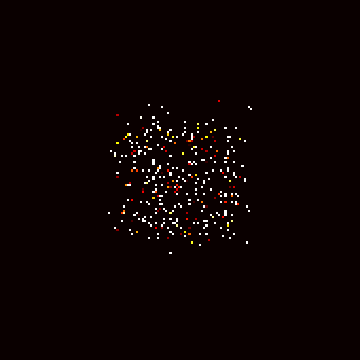
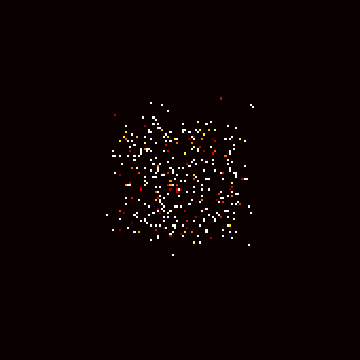
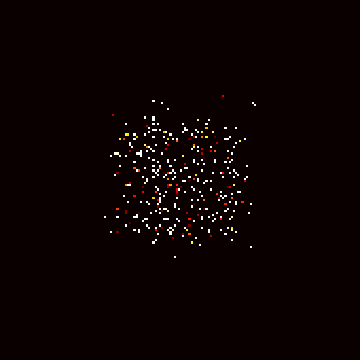
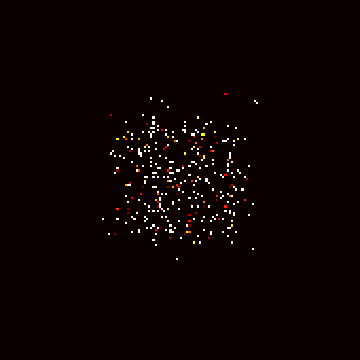
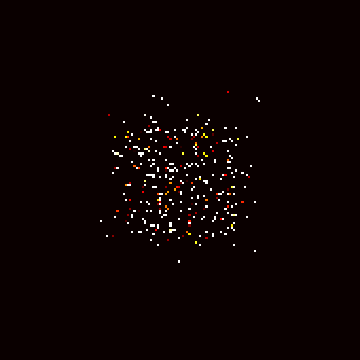
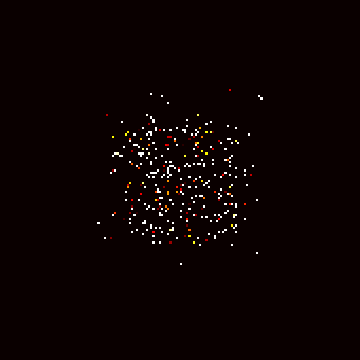
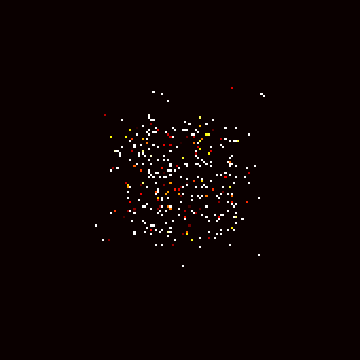
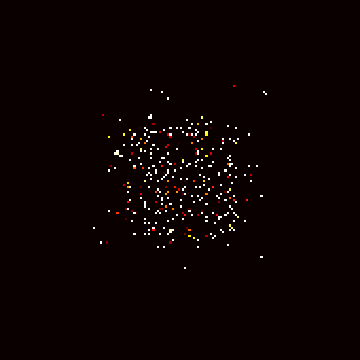
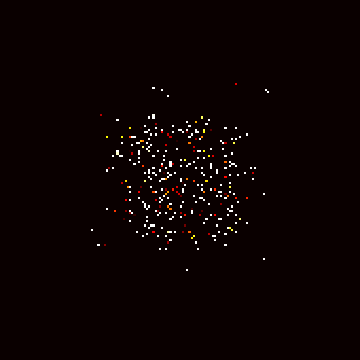
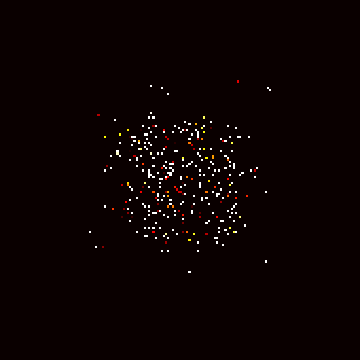
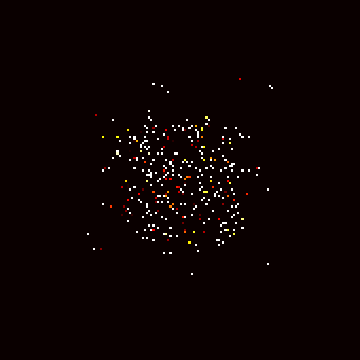
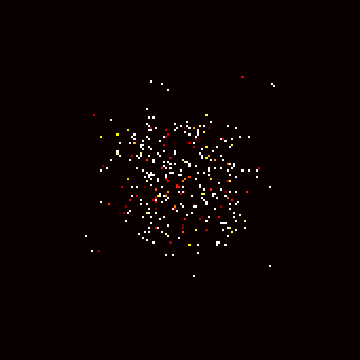
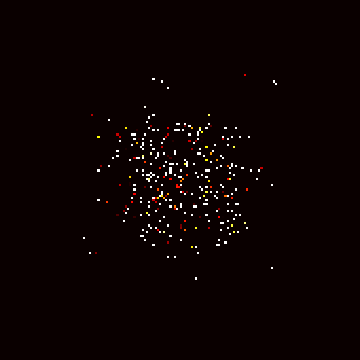
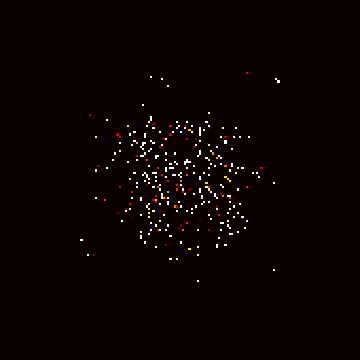
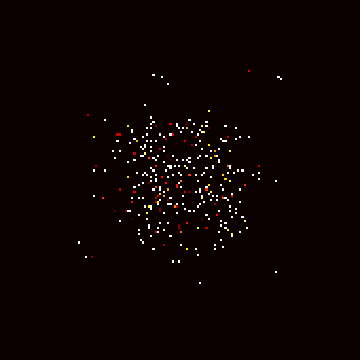
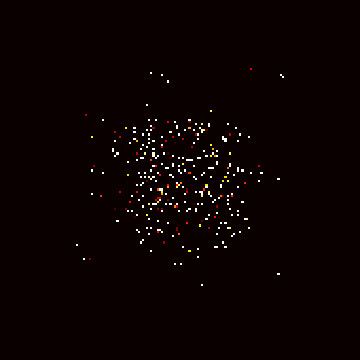
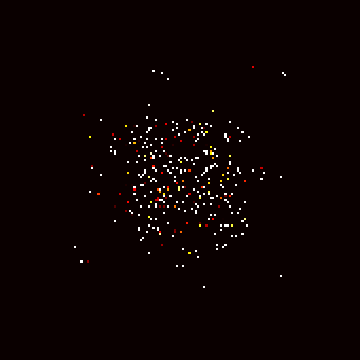
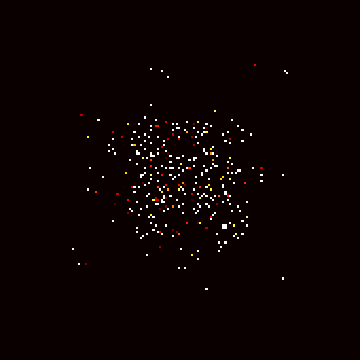
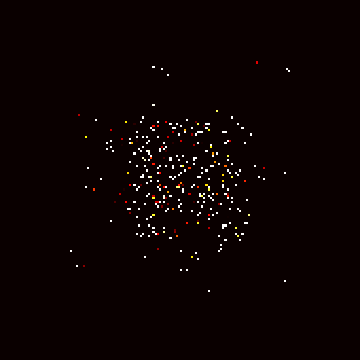
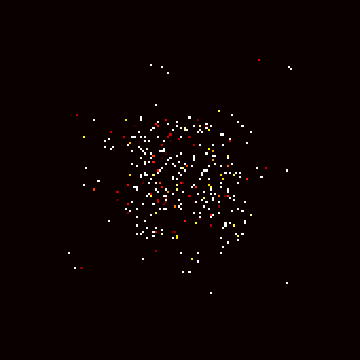
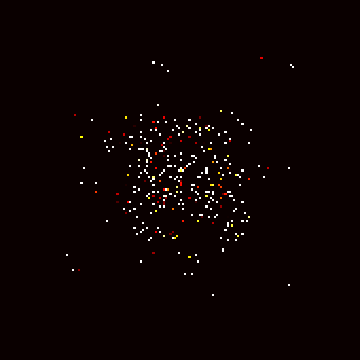
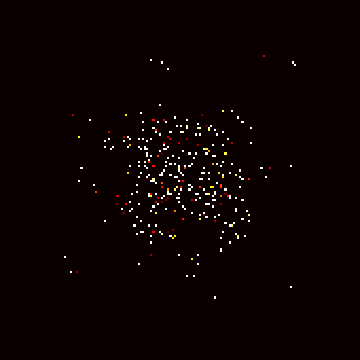
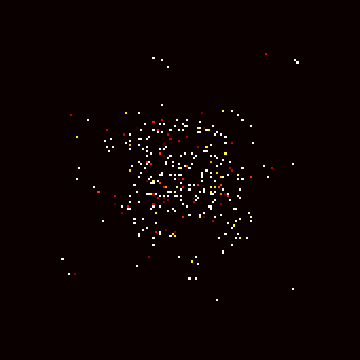
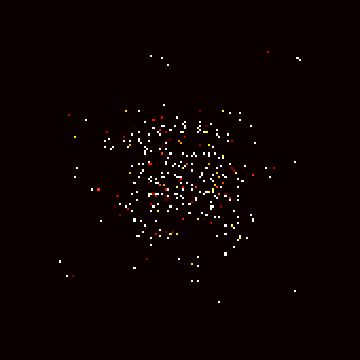
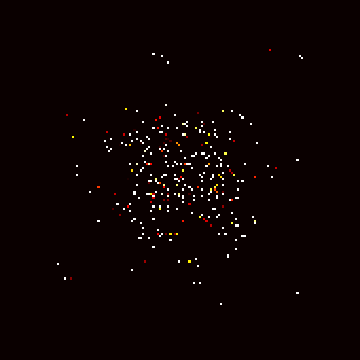
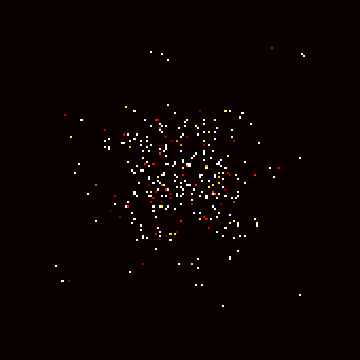
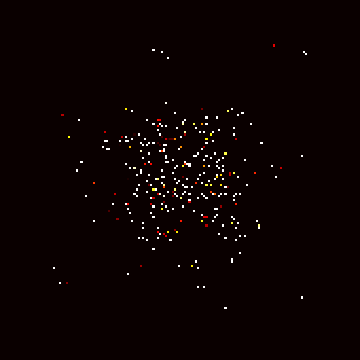
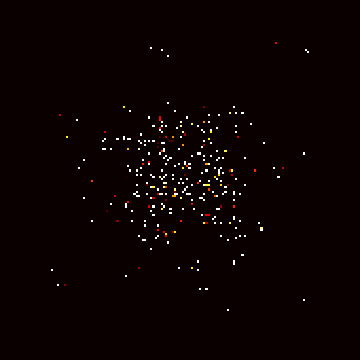
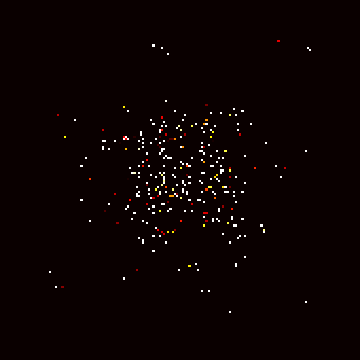
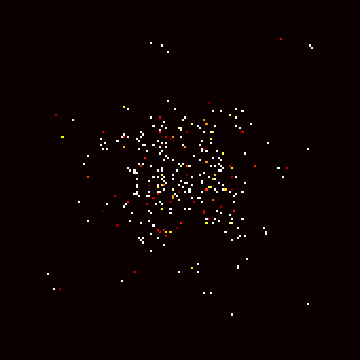
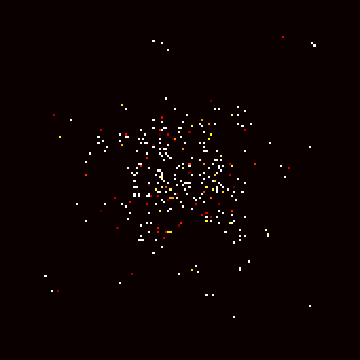
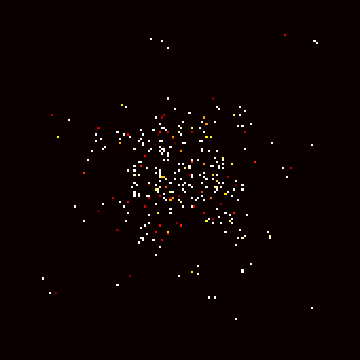
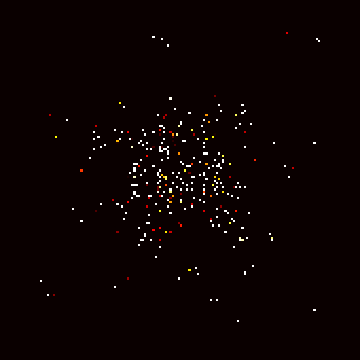
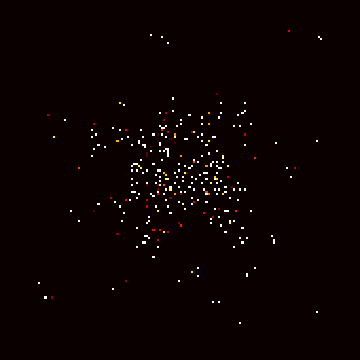
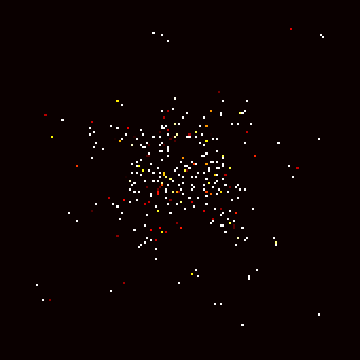
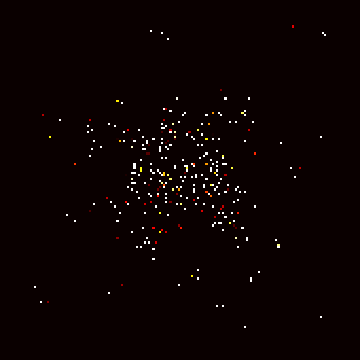
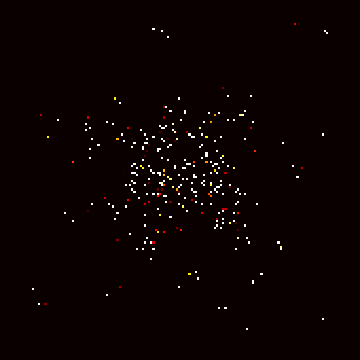
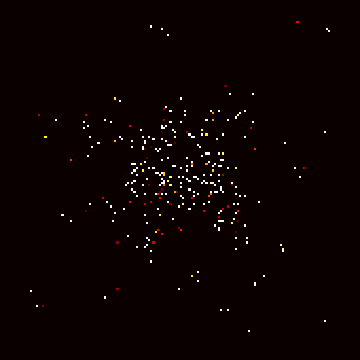
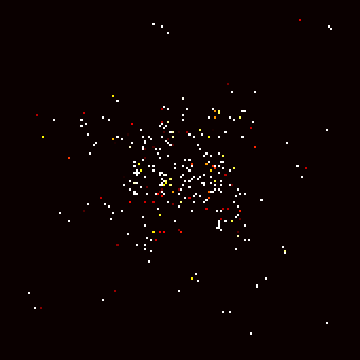
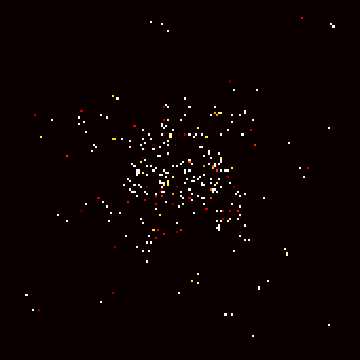
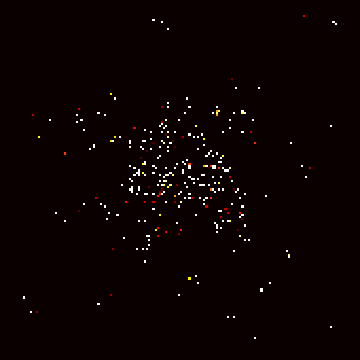
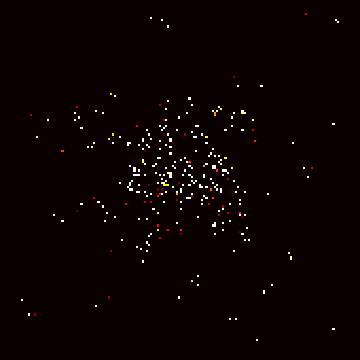
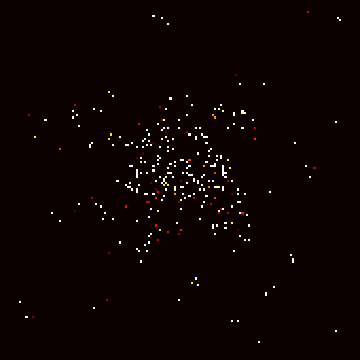
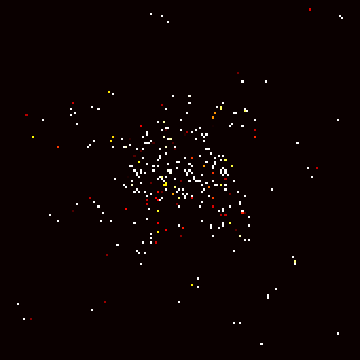
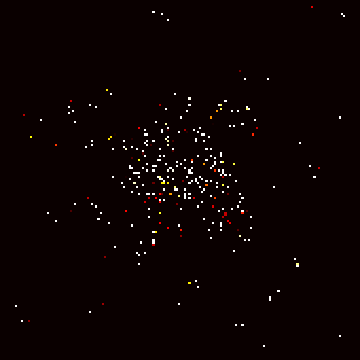
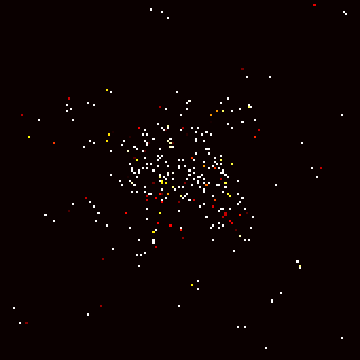
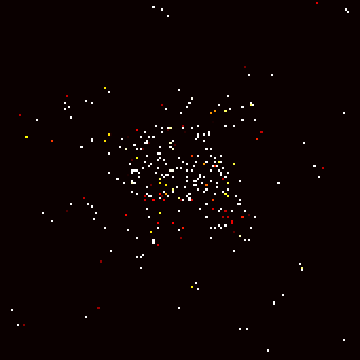
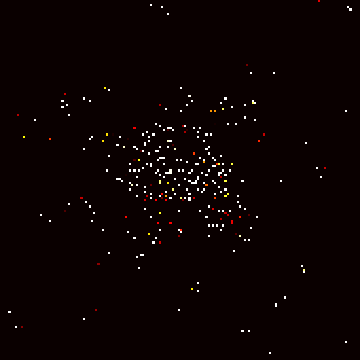
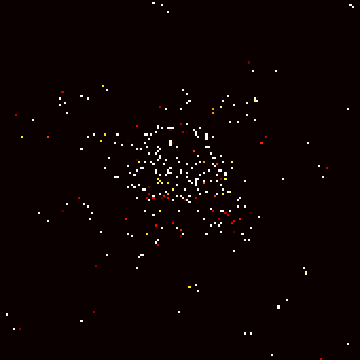
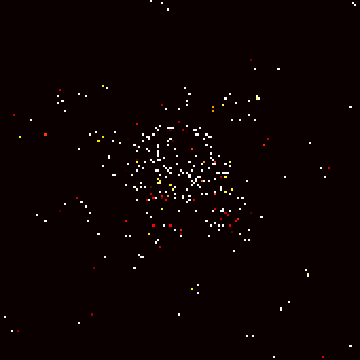
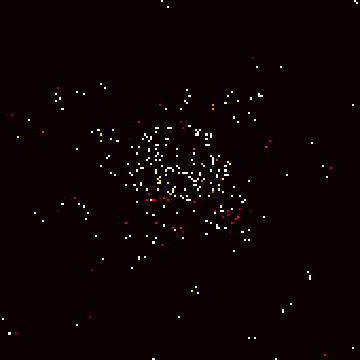
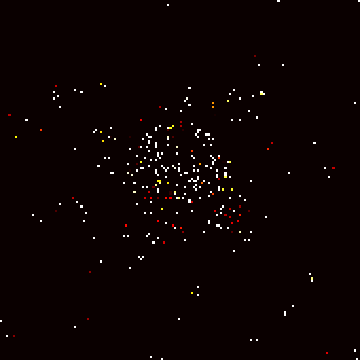
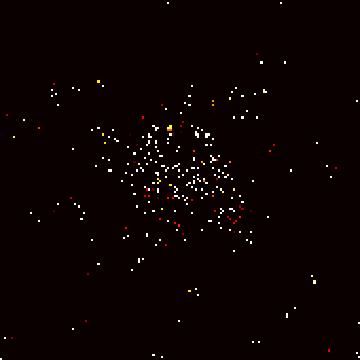
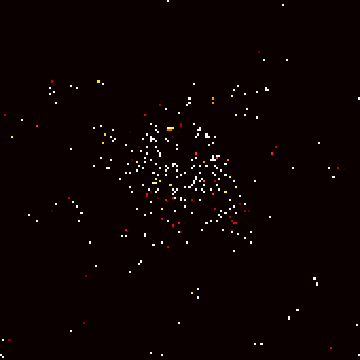
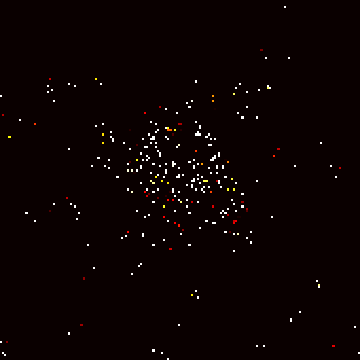
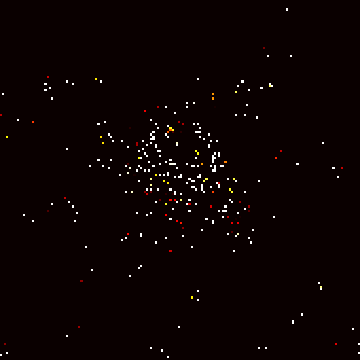
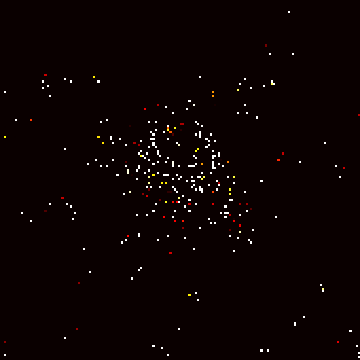
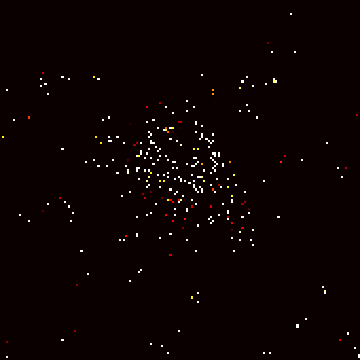
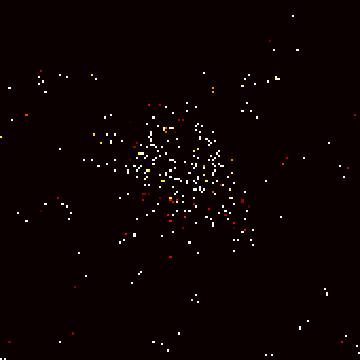
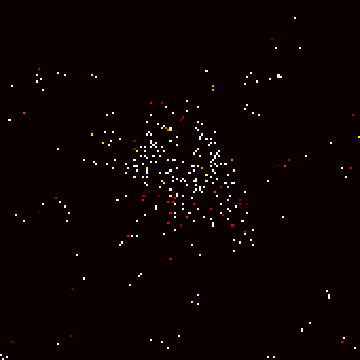
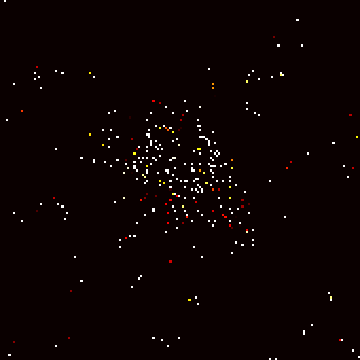
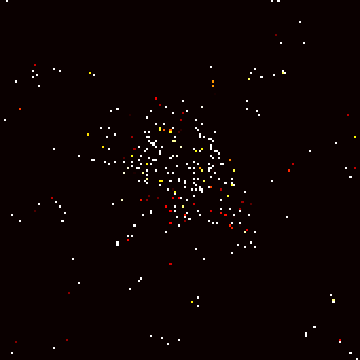
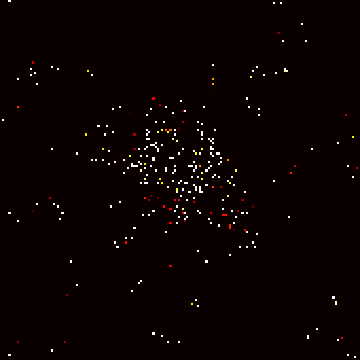
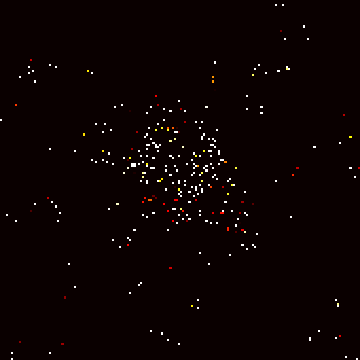
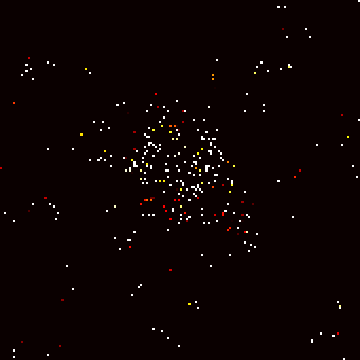
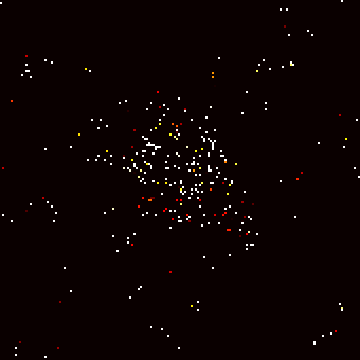
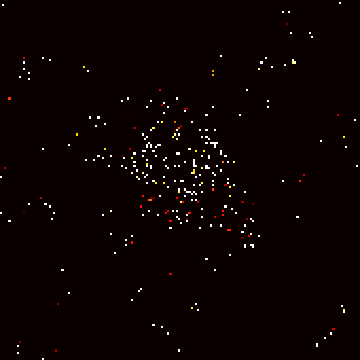
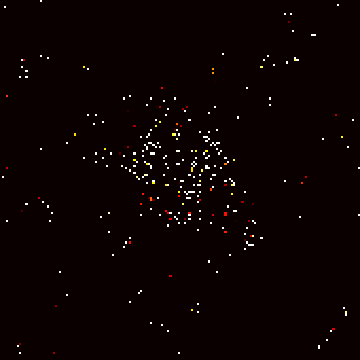
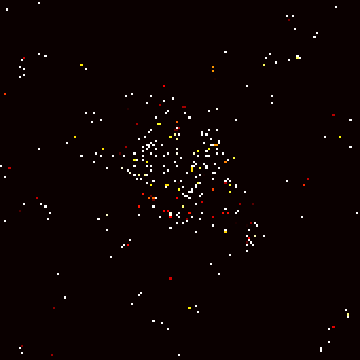
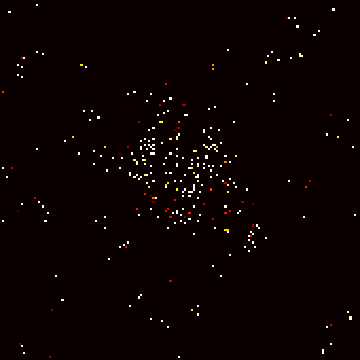
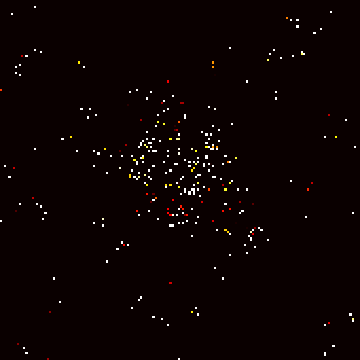
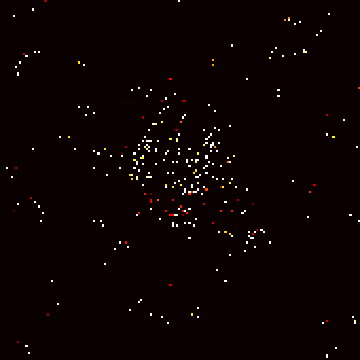
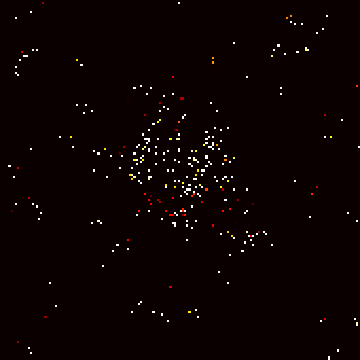
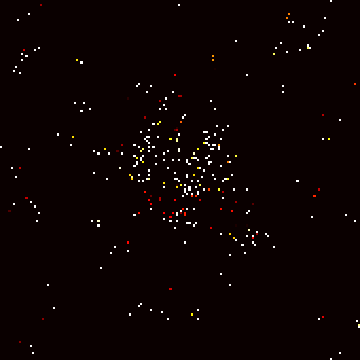
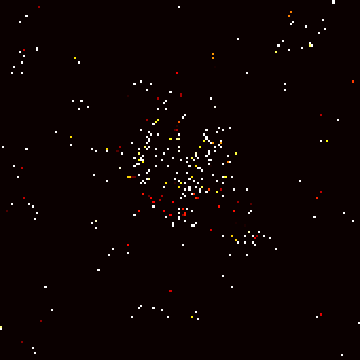
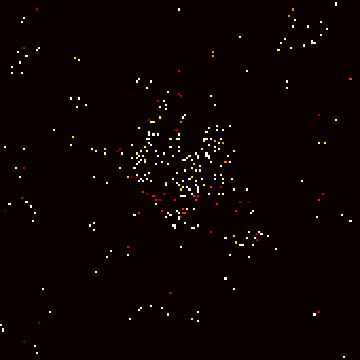
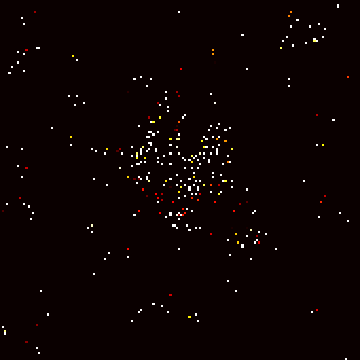
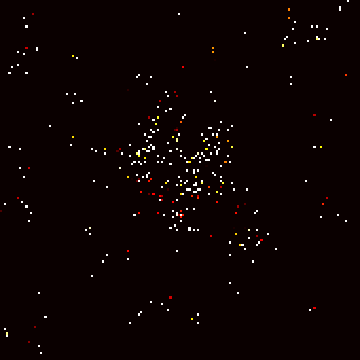
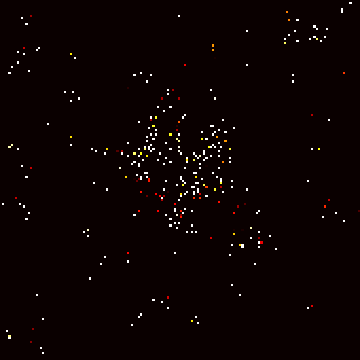
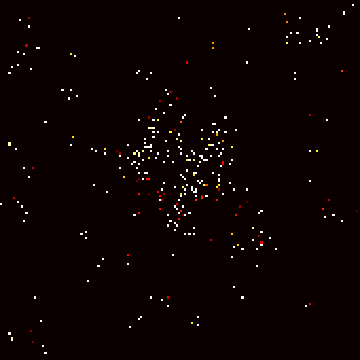
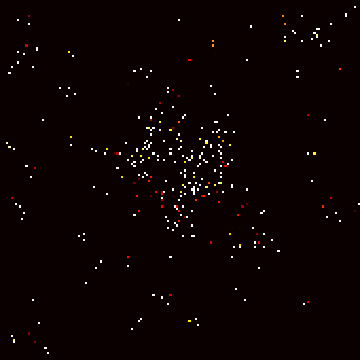
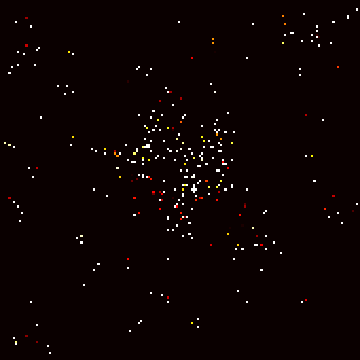
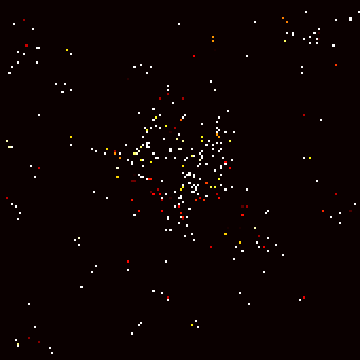
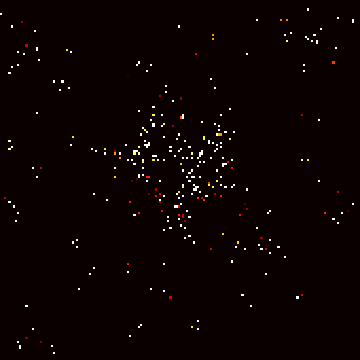
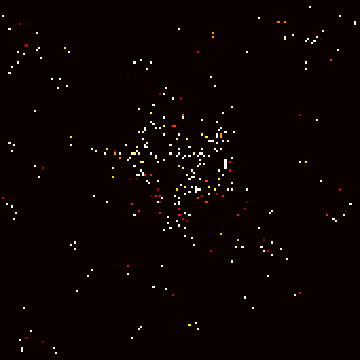
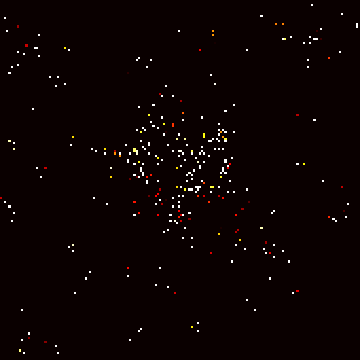
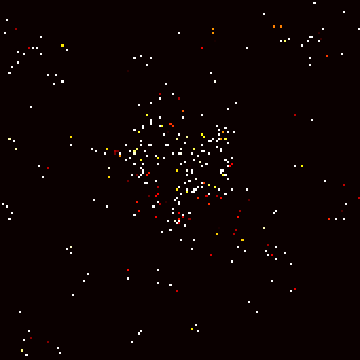
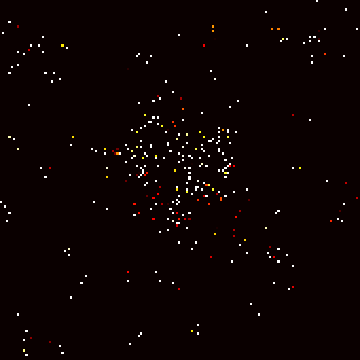
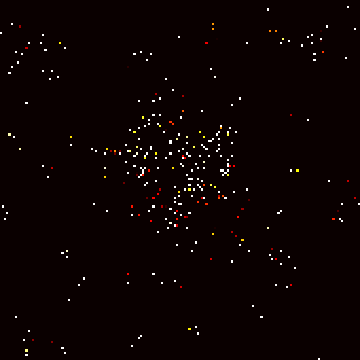
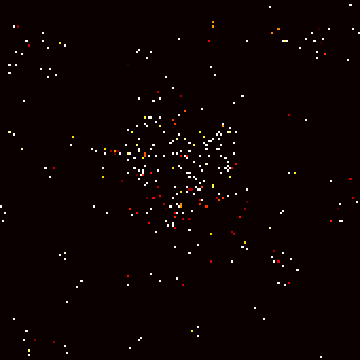

In [8]:
gr, c, cw, g, t, a = slime(start_pop=400, board_size=170, frames=100, max_hp=9, mutation_rate=20, log=False);gr

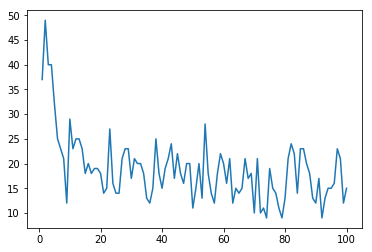

In [9]:
# Growth
plt.plot(t[:,0],t[:,1])

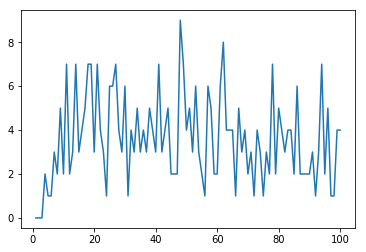

In [10]:
# Birth
plt.plot(t[:,0],t[:,2])

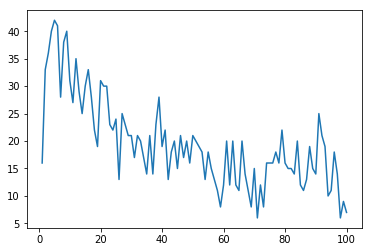

In [11]:
# Injuries
plt.plot(t[:,0],t[:,3])

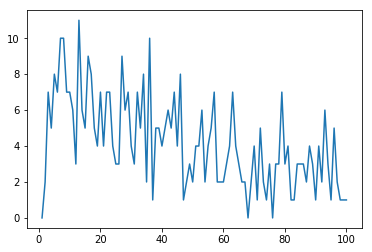

In [12]:
# Deaths
plt.plot(t[:,0],t[:,4])

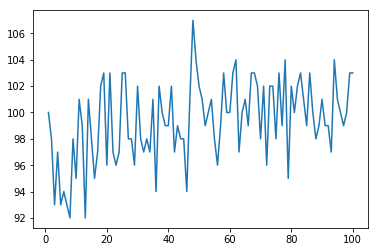

In [13]:
# Births-Deaths
plt.plot(t[:,0],100+t[:,2]-t[:,4])

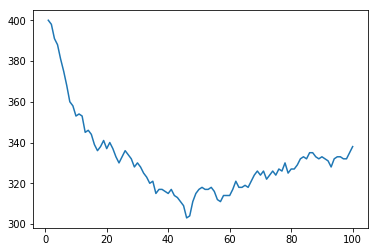

In [14]:
# Pop
plt.plot(t[:,0],t[:,5])

In [15]:
# Summary
t

array([[  1,  37,   0,  16,   0, 400],
       [  2,  49,   0,  33,   2, 398],
       [  3,  40,   0,  36,   7, 391],
       [  4,  40,   2,  40,   5, 388],
       [  5,  32,   1,  42,   8, 381],
       [  6,  25,   1,  41,   7, 375],
       [  7,  23,   3,  28,  10, 368],
       [  8,  21,   2,  38,  10, 360],
       [  9,  12,   5,  40,   7, 358],
       [ 10,  29,   2,  31,   7, 353],
       [ 11,  23,   7,  27,   6, 354],
       [ 12,  25,   2,  35,   3, 353],
       [ 13,  25,   3,  29,  11, 345],
       [ 14,  23,   7,  25,   6, 346],
       [ 15,  18,   3,  30,   5, 344],
       [ 16,  20,   4,  33,   9, 339],
       [ 17,  18,   5,  28,   8, 336],
       [ 18,  19,   7,  22,   5, 338],
       [ 19,  19,   7,  19,   4, 341],
       [ 20,  18,   3,  31,   7, 337],
       [ 21,  14,   7,  30,   4, 340],
       [ 22,  15,   4,  30,   7, 337],
       [ 23,  27,   3,  23,   7, 333],
       [ 24,  16,   1,  22,   4, 330],
       [ 25,  14,   6,  24,   3, 333],
       [ 26,  14,   6,  1

In [ ]:
nx.info(g)

In [ ]:
#import dill
#dill.dump_session('notebook_env.db')

In [ ]:
#import dill
#dill.load_session('notebook_env.db')